今天这个lecture，主要是讲了BN的用法，毫无疑问，我对BN的认识更加深刻了！！！在我看来这是值得的
此外，对于class的创造也更熟练了！
一、BN：
    BN是用来归一化隐藏层的输出，让激活函数能够处在一个更好的激活范围，不至于梯度消失！
    在训练过程中我们初始化权重矩阵的方法很重要，一个很好的方法就是根据kingming_norm的方式！
二、track：
    我们可以跟踪梯度、tanh（）的饱和率、以及grad ratio 来判断我们的模型训练效果！！！
三、总结
    这门课的难点不多，因为有前面两节课的基础，这节课的代码都很简单可以别出来，不过做ex02的时候，真的感觉思路很重要，只要思路清晰才能写出代码！！！

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
words = open('names.txt','r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
charts = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(charts)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_len = len(itos)
print(vocab_len)
print(itos)

27
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
block_size = 3

def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte , Yte = build_dataset(words[n2:])


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
#MLP 
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_len,n_embd),                 generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden),   generator=g) * (5/3) / ((n_embd * block_size) ** 0.5)#0.1
# b1 = torch.randn(n_hidden,                          generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_len),             generator=g) * 0.1
b2 = torch.randn(vocab_len,                         generator=g) * 0

# BatchNorm
bngain = torch.ones(1, n_hidden)
bnbias = torch.zeros(1, n_hidden)
bnmeam_running = torch.zeros(1, n_hidden)
bnstd_running = torch.ones(1, n_hidden)

parameters = [C, W1, bngain, bnbias, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True


12097


In [ ]:
#BatchNorm : bngain * (hpreact - bnmeani) / bnstd + bnbias
#将hidden layer的输出进行批归一化，然后在进行激活！！！但是因为我们只是在初始时希望符合0-1，并不希望所有情况下都是0-1
#因此使用一个bias 和gain 进行缩放和偏移，让模型自己学习，hidden——input应该如何进行分布，应该在空间中怎么进行移动，通过loss引导
#BatchNorm 类似一个正则化的作用，也类似数据增强（引入噪声），因此它能够防止模型过拟合，但是因为BN是对一个batch进行归一化，
#因此使得各个数据之间变得耦合，这并不好，由原来的线性--->到现在在激活前变得耦合了
#因此在很多的地方是用来LN等归一化
#因为在预测的时候也需要进行归一化，因此我们需要记录一个全局的均值和方差bnstd_running  bnmean_running，同时在训练的时候根据bnmean进行适当偏移
#在NLP中BN没有LN好用，因为在NLP中序列长度变化很大
#因为用了BN（-bnmean）因此一开始的偏差b1并没有用，可以去掉

In [49]:
max_steps = 1000
batch_size = 32
lossi = []

for i in range(max_steps):
    #batch
    ix = torch.randint(0, Xtr.shape[0],(batch_size,),generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    #forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0],-1)

    #Linear layer
    hpreact = embcat @ W1 #+ b1
    
    #BatchNorm
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstd + bnbias #这里bnstd没有加eplision，防止除零，因为不太可能出现0
    with torch.no_grad():
        bnmeam_running = 0.999 * bnmeam_running + 0.001 * bnmeani   
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstd  
    
    #hidden--layer
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb) #cross_entropy会自动softmax
    
    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i <100000 else 0.01
    for p in parameters:
        if p.grad is not None:
            p.data -= lr * p.grad
    
    #track stats
    if i% 1000 == 0:
        print(f'{i:7d}/{max_steps:7d}:{loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/   1000:3.5118


In [33]:
# 使用随机初始化的时候，初始loss很高26.5404，这不是我们希望的，在一开始，应该每个词的预测应该是均等的，所以logits应该是服从均匀分布，但是现在显然并非如此！
#我们需要在初始化的时候，就对其进行均等化，因此我们将b2=0，W2变小，使得得到的logits比较均匀 loss=4.15

(array([664., 278., 226., 157., 134., 117., 128.,  96.,  89., 105.,  86.,
         78.,  85.,  85.,  64.,  83.,  69.,  74.,  62.,  77.,  71.,  44.,
         65.,  50.,  77.,  66.,  62.,  59.,  55.,  88.,  66.,  83.,  71.,
         74.,  71.,  62.,  88.,  76.,  84.,  76.,  78., 112., 117., 117.,
        140., 160., 175., 219., 356., 781.]),
 array([-9.99991179e-01, -9.59991490e-01, -9.19991801e-01, -8.79992112e-01,
        -8.39992423e-01, -7.99992734e-01, -7.59993045e-01, -7.19993356e-01,
        -6.79993668e-01, -6.39993979e-01, -5.99994290e-01, -5.59994601e-01,
        -5.19994912e-01, -4.79995223e-01, -4.39995534e-01, -3.99995846e-01,
        -3.59996157e-01, -3.19996468e-01, -2.79996779e-01, -2.39997090e-01,
        -1.99997401e-01, -1.59997712e-01, -1.19998024e-01, -7.99983346e-02,
        -3.99986458e-02,  1.04308128e-06,  4.00007319e-02,  8.00004208e-02,
         1.20000110e-01,  1.59999799e-01,  1.99999487e-01,  2.39999176e-01,
         2.79998865e-01,  3.19998554e-01,  3.59998

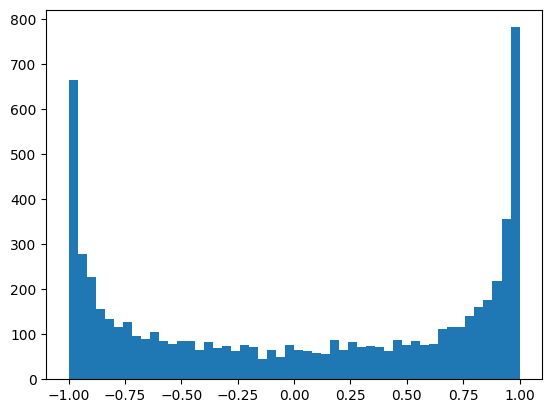

In [44]:
plt.hist(h.view(-1).tolist(), 50) #tanh 可以发现很多值都是在-1，1但是tanh在-1， 1中的导数为0，这就可能会出现导数消失的问题！！！
#原因是因为hpreact是embcat @ W1 + b1获得，然而这几个都是随机初始化的，最后得到的结果距离0比较远，所以我们可以降低W和b，与loss处理方式一样

In [ ]:
#在现实中，我们不可能会手动设置，因此我们需要靠考虑的是如何才能让尽可能少的数据落在平坦区间
#毫无疑问，我们用的最多的就是正态分布，但是尽管我们在初始化的时候采用了正太分布，但是由于神经网络中用的是乘法，因此方差会不断的
#增加，这样会使得越来越多的值落在平坦区域！！！
#有一个方法是将w / (input) ** 0.5 这能保持方差仍然是一，但是很麻烦，另一个方法就是BN
#这里还采用了一个方法：kaiming_nomalizaion 给出了W * what  对于tanh  为(5/3) / ((n_embd * block_size) ** 0.5)
#实际上使用BN更省事

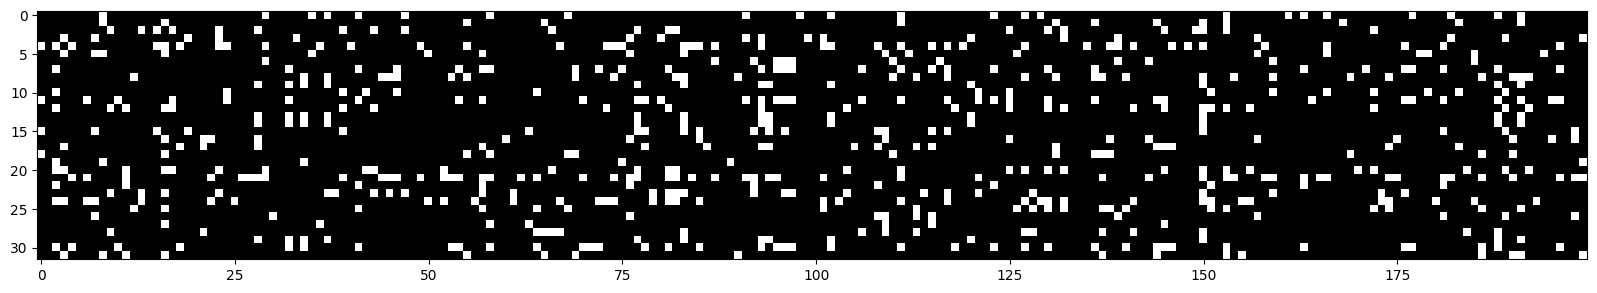

In [46]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

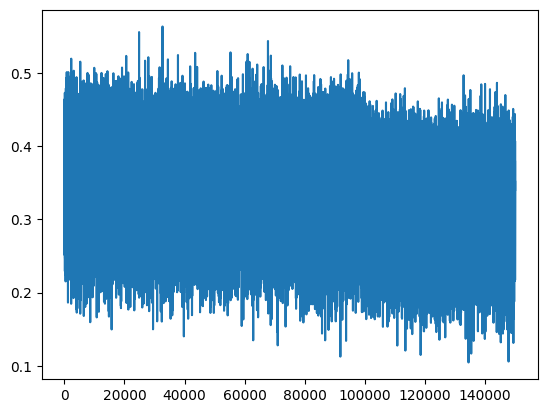

In [13]:
plt.plot(lossi)

In [ ]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train':{Xtr, Ytr},
        'val':{Xdev, Ydev},
        'test':{Yte, Yte}
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0],-1)
    #BN
    hpreact = embcat @ W1
    hpreact = bngain * (hpreact - bnmeam_running) / bnstd_running + bnbias
    h = torch.tanh( hpreact )
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item()) 
split_loss('train')
split_loss('val')

train 2.4183733463287354
val 2.423733711242676


In [21]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(10):

    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(emb.shape[0],-1) @ W1 + b1)
        logits = h @ W2 + b2 
        prob = F.softmax(logits,dim=1)
        ix = torch.multinomial(prob, num_samples=1, replacement=True, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

roz.
jerik.
kash.
con.
palver.
mucklenot.
yunaciel.
bexsaverta.
sardiegh.
paxterrald.


In [50]:
# SUMMARY + PYTORCHIFYING -----------

In [ ]:
#class  The classes we create here are the same API as nn.Module in PyTorch
import torch
import torch.nn.functional as F
class Linear:

    def __init__(self, fan_in, fan_out, bias = True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in ** 0.5
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias]) #这里括号提高优先级

class BatchNorm1d:
    
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        #buffers
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.std(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        #update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

def fold_fused(linear, bn):
    assert isinstance(linear,Linear) and isinstance(bn, BatchNorm1d)

    std = torch.sqrt(bn.running_var + bn.eps)
    W = linear.weight
    if linear.bias is None:
        b = torch.zeros(W.shape[1])
    else:
        b = linear.bias
    
    W_new = (bn.gamma / std).unsqueeze(0) * W
    b_new = bn.gamma * (b - bn.running_mean) / std + bn.beta

    return W_new, b_new


n_embd = 10
n_hidden = 100

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_len,n_embd),            generator=g)
print(C.shape)
layers = [
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, vocab_len, bias=False), BatchNorm1d(vocab_len),
]

with torch.no_grad():
    # last layer: make less confident
    layers[-1].gamma *= 0.1
    #layers[-1].weight *= 0.1
    # all other layers: apply gain, expect last layer
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
          layer.weight *= 5/3  #kingming norm
#weight的大小会影响到后面的tanh函数的输出，weiht太小会导致tanh的饱和度很低，模型根本没学到什么，因此我们需要适中的weight，让饱和度不高也不低，可以参考kingming——Norma
#每层大致相等，没有爆炸没有归零就是比较好


parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

torch.Size([27, 10])
47024


In [10]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
     # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.2866


In [11]:
# fold the BN to Linear
fold_layers = []
i = 0

while i < len(layers):
    if isinstance(layers[i], Linear) and isinstance(layers[i+1], BatchNorm1d):
        layers[i+1].training = False
        W_new, b_new = fold_fused(layers[i], layers[i+1])
        new_linear = Linear(W_new.shape[0], W_new.shape[1])
        new_linear.weight = W_new
        new_linear.bias = b_new
        fold_layers.append(new_linear)
        i+=2
    else:
        fold_layers.append(layers[i])
        i+=1

In [20]:
x = torch.randn(10, block_size * n_embd)

out1 = x 
for l in layers:
    out1 = l(out1)
out2 = x
for l in fold_layers:
    out2 = l(out2)

print("Max difference after folding:", (out1 - out2).abs().max().item())


Max difference after folding: 1.0728836059570312e-06


layer 2 (      Tanh): mean -0.00, std 0.70, saturated: 7.78%
layer 5 (      Tanh): mean -0.01, std 0.66, saturated: 4.41%
layer 8 (      Tanh): mean -0.01, std 0.66, saturated: 3.94%
layer 11 (      Tanh): mean -0.01, std 0.67, saturated: 4.47%
layer 14 (      Tanh): mean -0.00, std 0.67, saturated: 4.09%


Text(0.5, 1.0, 'activation distribution')

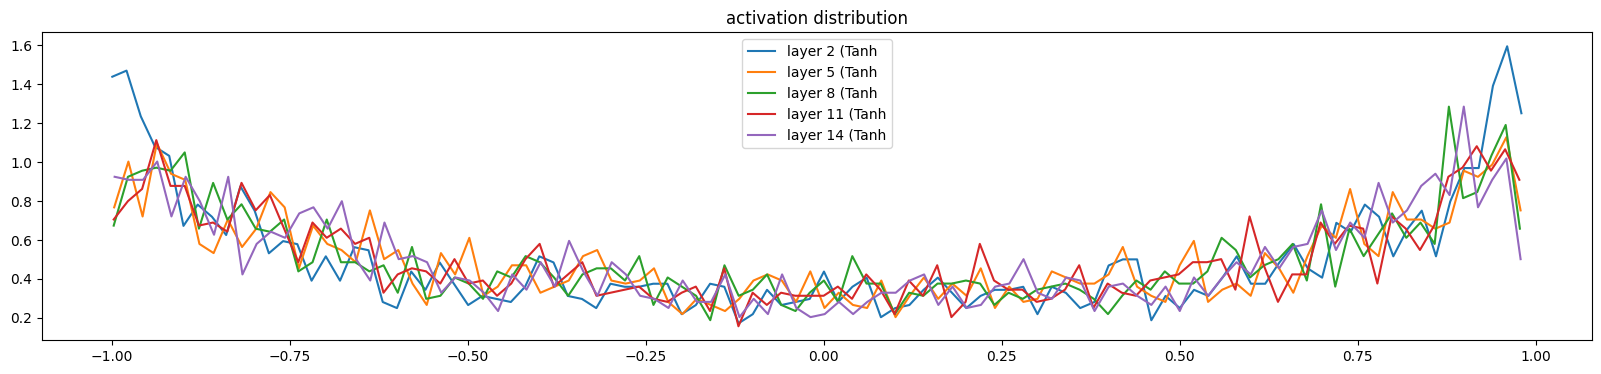

In [71]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out  #tanh 的值
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends)
plt.title('activation distribution')

layer 2 (      Tanh): mean -0.000000, std 3.724780e-03
layer 5 (      Tanh): mean -0.000000, std 3.343457e-03
layer 8 (      Tanh): mean +0.000000, std 3.024398e-03
layer 11 (      Tanh): mean +0.000000, std 2.615304e-03
layer 14 (      Tanh): mean +0.000000, std 2.344963e-03


Text(0.5, 1.0, 'gradient distribution')

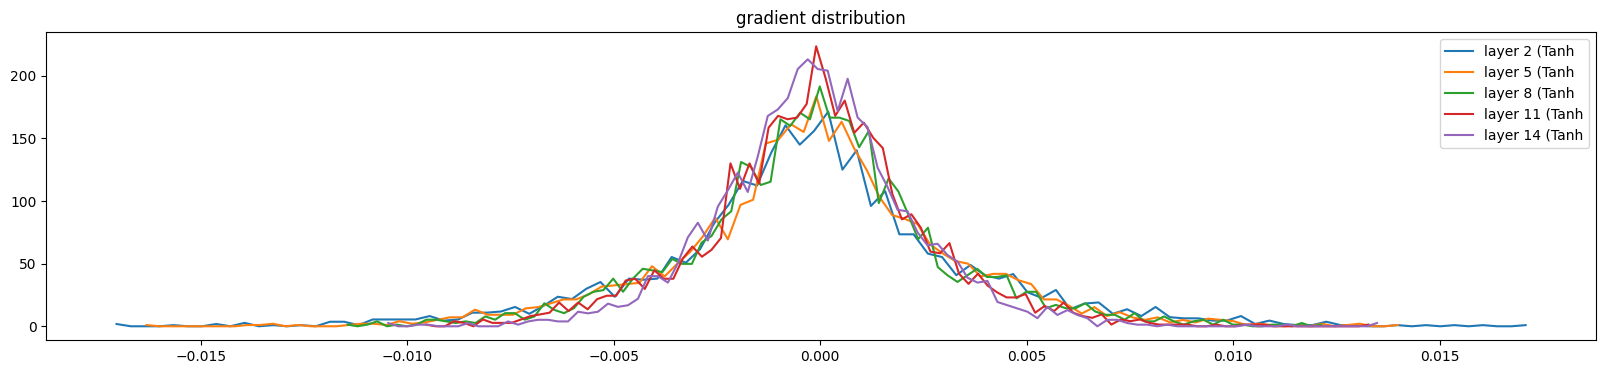

In [72]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends)
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000000 | std 1.080885e-02 | grad:data ratio 1.080721e-02
weight  (30, 100) | mean -0.000074 | std 9.417354e-03 | grad:data ratio 3.015230e-02
weight (100, 100) | mean +0.000117 | std 8.068180e-03 | grad:data ratio 4.824394e-02
weight (100, 100) | mean +0.000063 | std 6.951377e-03 | grad:data ratio 4.120953e-02
weight (100, 100) | mean -0.000015 | std 5.883446e-03 | grad:data ratio 3.503324e-02
weight (100, 100) | mean -0.000022 | std 5.043986e-03 | grad:data ratio 3.000954e-02
weight  (100, 27) | mean -0.000033 | std 9.334476e-03 | grad:data ratio 5.494798e-02


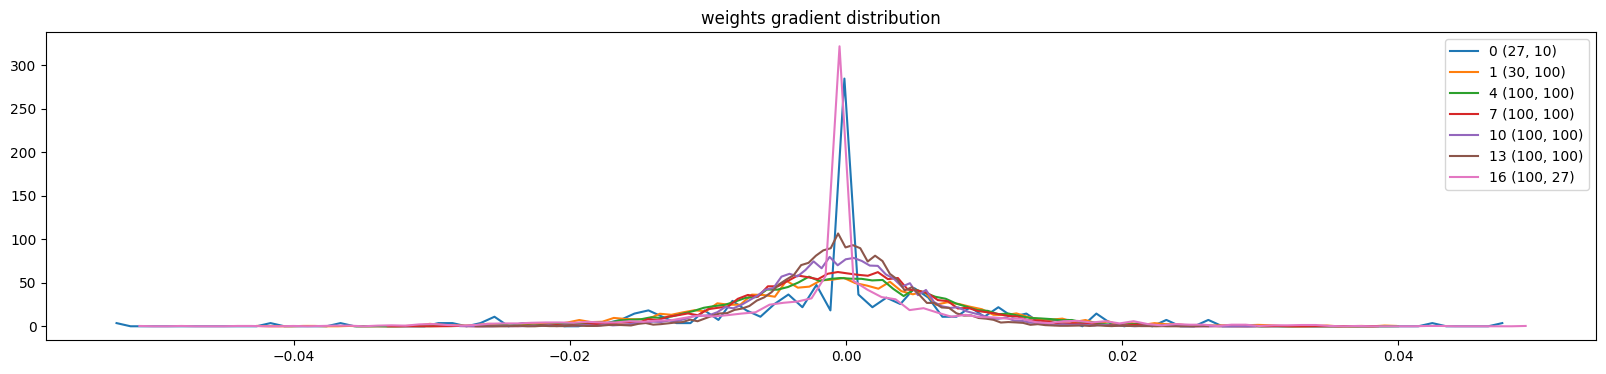

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution')

#最后一层的训练一般更快一点，所以随着训练的时间增大grad:data ratio会变得比其他层大很多！！！

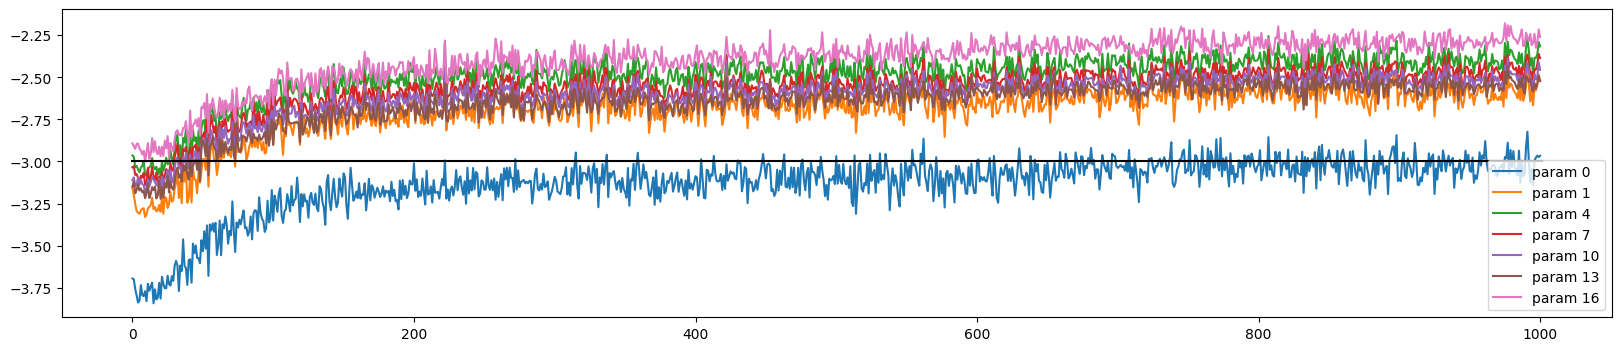

In [74]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends)

In [63]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 2.4174351692199707
val 2.416332721710205


In [64]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

chamahxqaillleihkimrixrenty.
halassie.
rahnen.
del.
ric.
kaqhiu.
ramari.
chaiiv.
kalein.
dhym.
join.
qhijthn.
lilea.
jadbq.
wazelogdiaryxixfi.
eklinsan.
ed.
ecoia.
gtleley.
riyah.
